<a href="https://colab.research.google.com/github/LorenaDeveloper/Iris_Eye_Model/blob/main/2021_12_7_KERAS_CNN_KerasTuner_Best_Weights_PINK_Visualizacion_09792Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#TENSORBOARD
# Carga la extensión TensorBoard notebook 
#%load_ext tensorboard

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import os
import datetime
import warnings                   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorboard import notebook
%matplotlib inline

In [ ]:
# TENSORBOARD Limpia los logs de previos runs
#rm -rf ./logs/


In [ ]:
#Código para borrar carpetas con contenido del directorio local
#from shutil import rmtree
#rmtree('/content/my_dir')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATADIR = '/content/drive/MyDrive/Colab Notebooks/dataset/AMP_COLOR_PINK_training_dataset'
CATEGORIES = ['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow']
IMG_SIZE=32

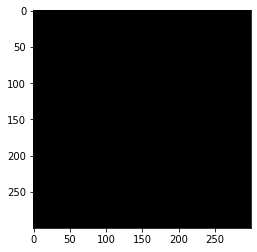

In [ ]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

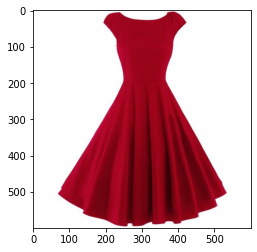

In [ ]:
#Visualizacion correcta RGB plt.imshow agregando cv2.cvtColor
img_array=cv2.imread('/content/drive/MyDrive/Colab Notebooks/dataset/AMP_COLOR_PINK_training_dataset/red/ORIG_red_1.jpg')
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

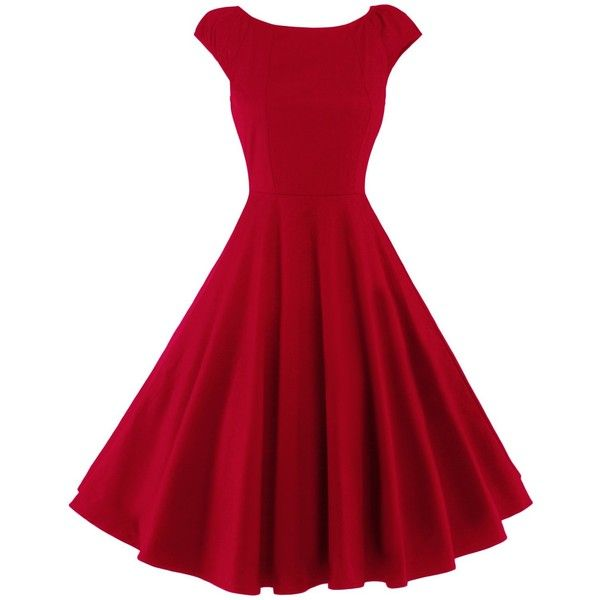

In [ ]:
#Correcta visualización de imágenes utilizando cv2.imshow (muestra correctamente bgr) con patches de google colab (directamente importado de cv2 está capado)
img_array=cv2.imread('/content/drive/MyDrive/Colab Notebooks/dataset/AMP_COLOR_PINK_training_dataset/red/ORIG_red_1.jpg')
cv2_imshow(img_array)

Creamos el conjunto de datos de entrenamiento

In [ ]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

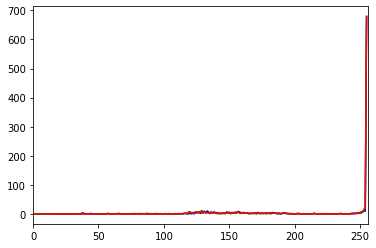

In [ ]:
#Visualizamos el histograma rgb de una de las imágenes del conjunto de datos de entrenamiento
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([training_data[310][0]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

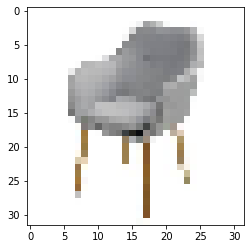

In [ ]:
#Mostramos en pantalla la imagen del histograma anterior
img_rgb = cv2.cvtColor(training_data[310][0], cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
#Comprobamos la etiqueta de la imagen mostrada
print(training_data[310][1])

4


In [ ]:
print(len(training_data))

770


In [ ]:
lenofimage = len(training_data)

Separamos los datos en características y clases

In [ ]:
#Hay que modificar la forma porque para pasarle los datos a la red neuronal tienen que tener 
#formato = tensor [NumMuestras, NumFilas, NumCols, NumCanalesColor]

X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,IMG_SIZE,IMG_SIZE,3)
##X = tf.keras.utils.normalize(X, axis = 1)

In [ ]:
#Convertimos la lista y en un array 
y = np.array(y)

In [ ]:
#Comprobamos la forma de los array de datos x e y
print(X.shape)
print(y.shape)

(770, 32, 32, 3)
(770,)


In [ ]:
#print(X[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


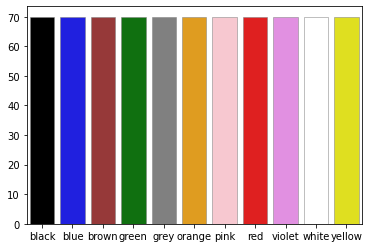

In [ ]:
# Visualizamod el histograma de las clases,para comprobar si está balanceado
ser = pd.Series(y)
table = ser.value_counts()
table = table.sort_index()                                         # tiene que ser ordenado para que el etiquetado sea correcto.
sns.barplot(CATEGORIES,table.values,linewidth=0.5,edgecolor='grey', palette=['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow'])
plt.show()

Prepocesado de datos

In [ ]:
# Normalizamos los en conjunto de datos dividiéndolo por su máximo valor (max. valor canales rgb)
X = X/255.0
print(X.min())
print(X.max())

0.0
1.0


In [ ]:
# Ejemplo de array 'flattened' ...
#X[60]

Dividimos los datos en conjunto de train y test

In [ ]:
#Dividimos los datos en conjunto de train y test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123)

In [ ]:
#Hacemos una codificación one-hot de la variable de salida (num classes = 10)
y_trainFinal = to_categorical(y_train,num_classes=11)
y_testFinal = to_categorical(y_test,num_classes=11)

In [ ]:
#Comprobamos que se ha realizado correctamente mostrando el primer valor antes y después de normalizar
print(y_train[10],y_trainFinal[10])

8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
#Comprobamos que los tensores tienen la dimensión correcta para pasarlos a la red neuronal
# tensor X = [NumMuestras, NumFilas, NumCols, NumCanalesColores]
# tensor Y = [NumMuestras, NumClasses]

print(X_train.shape)
print(X_test.shape)
print(y_trainFinal.shape)
print(y_testFinal.shape)

(577, 32, 32, 3)
(193, 32, 32, 3)
(577, 11)
(193, 11)


In [ ]:
#Comprobamos que todos los conjuntos de datos están correctamente normalizados y codificados
print(np.min(X_train), np.max(X_train)) #El max y mín de la matriz de datos train serán 0 y 1 al estar normalizados
print(np.min(X_test), np.max(X_test)) #El max y mín de la matriz de datos test serán 0 y 1 al estar normalizados
print(np.min(y_train), np.max(y_train)) #Miramos el max y min de la variable de salida (clases de 0 a 9)

0.0 1.0
0.0 1.0
0 10


OPTIMIZACIÓN DE HIPERPARÁMETROS RED NEURONAL CONVOLUCIONAL CON KERAS TUNER

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 3.2 MB/s 


In [ ]:
def build_model(hp):
    # crea el objeto model
    model = keras.Sequential([
    #añade la primera capa convolucional
    keras.layers.Conv2D(
        #añade filtro
        filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=8),
        # añade tamaño de filtro o tamaño de kernel
        kernel_size=hp.Choice('conv_1_kernel', values = [3,6]),
        #función de activación
        activation='relu',
        input_shape=(32,32,3)),
    #añade capa maxpooling
    keras.layers.MaxPool2D(pool_size=2),
    # añade segunda capa convolucional
    keras.layers.Conv2D(
        #añade filtro 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        #añade tamaño de filtro o tamaño de kernel
        kernel_size=hp.Choice('conv_2_kernel', values = [3,6]),
        #función de activación
        activation='relu'),
    #añade capa maxpooling
    keras.layers.MaxPool2D(pool_size=2),
    # añade tercera capa convolucional  -> no necesaria finalmente
    #keras.layers.Conv2D(
        #añade filtro 
        #filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=16),
        #añade tamaño de filtro o tamaño de kernel
        #kernel_size=hp.Choice('conv_3_kernel', values = [3,6]),
        #función de activación
        #activation='relu'),
    #añade capa maxpooling
    #keras.layers.MaxPool2D(pool_size=2),
    # añade capa flatten    
    keras.layers.Flatten(),
    # añade capa densa    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
        activation='relu'),  
    #capa dropout
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
    # capa dropout    
    keras.layers.Dense(11, activation='softmax')
    ])
    #compilación del modelo
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=120,
                     factor=3,
                     directory='my_dir',
                     project_name='kt_3')

In [ ]:
#Define callback, parará el entrenamiento si "val_loss" no ha mejorado en 5 epocas.
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
    )

In [ ]:
# busca mejor parámetro
tuner.search(X_train, 
             y_trainFinal, 
             validation_split=0.2, 
             callbacks=[stop_early])

Trial 254 Complete [00h 00m 08s]
val_accuracy: 0.8879310488700867

Best val_accuracy So Far: 0.9051724076271057
Total elapsed time: 00h 12m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Optiene hyperparametros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	best_hps.get("conv_1_filter")))
print("[INFO] optimal size of kernel in conv_1 layer: {}".format(
	best_hps.get("conv_1_kernel")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	best_hps.get("conv_2_filter")))
print("[INFO] optimal size of kernel in conv_2 layer: {}".format(
	best_hps.get("conv_2_kernel")))
#print("[INFO] optimal number of filters in conv_3 layer: {}".format(
	#best_hps.get("conv_3_filter")))
#print("[INFO] optimal size of kernel in conv_3 layer: {}".format(
	#best_hps.get("conv_3_kernel")))
print("[INFO] optimal number of units in dense layer: {}".format(
	best_hps.get("dense_1_units")))
print("[INFO] optimal dropout: {:.4f}".format(
	best_hps.get("dropout")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))


[INFO] optimal number of filters in conv_1 layer: 48
[INFO] optimal size of kernel in conv_1 layer: 3
[INFO] optimal number of filters in conv_2 layer: 64
[INFO] optimal size of kernel in conv_2 layer: 6
[INFO] optimal number of filters in conv_3 layer: 384
[INFO] optimal dropout: 0.0000
[INFO] optimal learning rate: 0.0001


In [ ]:
#Construimos el modelo con los mejores parámetros
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 48)        1344      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 48)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        110656    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 384)              

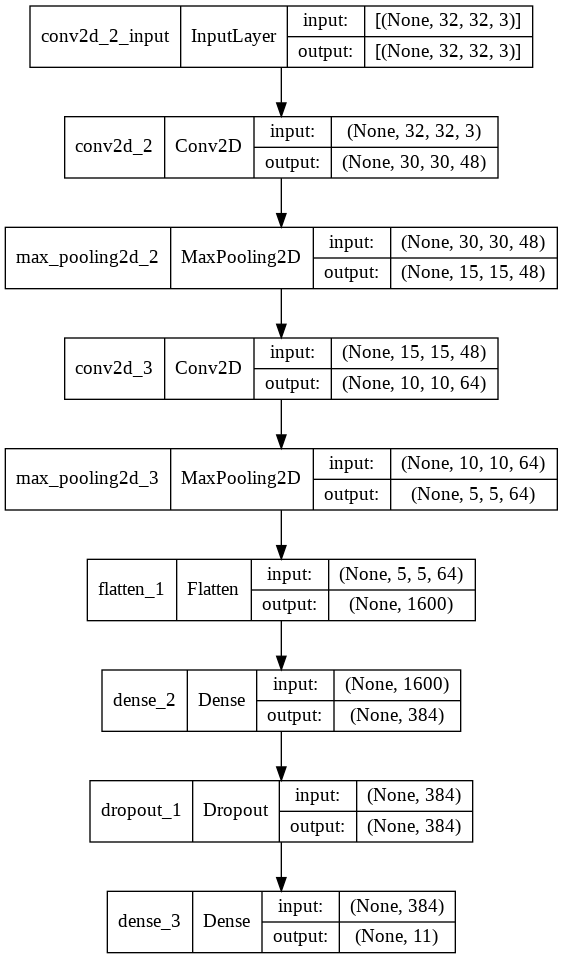

In [ ]:
#Visualizamos la misma información pero de manera más gráfica
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True) #LR hace que muestre el mismo dibujo pero de izq a drcha

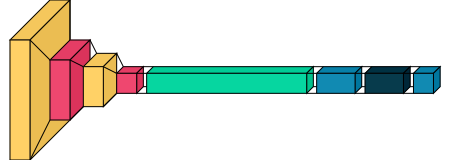

In [ ]:
!pip install visualkeras
import visualkeras


visualkeras.layered_view(model).show() 
visualkeras.layered_view(model, to_file='output.png') # escribe en memoria
visualkeras.layered_view(model, to_file='output.png').show() # escribe y muestra

visualkeras.layered_view(model)

In [ ]:
#VISUALIZACION TENSORBOARD
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#Entrenamos el modelo
history = model.fit(
    X_train, 
    y_trainFinal, 
    epochs=200, 
    validation_split=0.2, 
    verbose=2,
    #callbacks=[tensorboard_callback]
    )

val_acc_per_epoch = history.history['val_accuracy']
best_acc = np.max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best accuracy: %d' % (best_acc,))
print('Best epoch: %d' % (best_epoch,))


Epoch 1/200
15/15 - 1s - loss: 2.2645 - accuracy: 0.1866 - val_loss: 2.1692 - val_accuracy: 0.1897 - 990ms/epoch - 66ms/step
Epoch 2/200
15/15 - 0s - loss: 1.9615 - accuracy: 0.3471 - val_loss: 1.8055 - val_accuracy: 0.4310 - 149ms/epoch - 10ms/step
Epoch 3/200
15/15 - 0s - loss: 1.6139 - accuracy: 0.4859 - val_loss: 1.4636 - val_accuracy: 0.6034 - 156ms/epoch - 10ms/step
Epoch 4/200
15/15 - 0s - loss: 1.3013 - accuracy: 0.6009 - val_loss: 1.2132 - val_accuracy: 0.6293 - 153ms/epoch - 10ms/step
Epoch 5/200
15/15 - 0s - loss: 1.0632 - accuracy: 0.6659 - val_loss: 1.0201 - val_accuracy: 0.6379 - 143ms/epoch - 10ms/step
Epoch 6/200
15/15 - 0s - loss: 0.9005 - accuracy: 0.6811 - val_loss: 0.8999 - val_accuracy: 0.6724 - 156ms/epoch - 10ms/step
Epoch 7/200
15/15 - 0s - loss: 0.7981 - accuracy: 0.7332 - val_loss: 0.7950 - val_accuracy: 0.6897 - 155ms/epoch - 10ms/step
Epoch 8/200
15/15 - 0s - loss: 0.7003 - accuracy: 0.7570 - val_loss: 0.7513 - val_accuracy: 0.7845 - 139ms/epoch - 9ms/step
E

In [ ]:
#VISUALIZACIÓN TENSORBOARD
#%tensorboard --logdir logs/fit

In [ ]:
#VISUALIZACIÓN TENORBOARD (otro modo)
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances

In [ ]:
#Definimos el hypermodelo con los mejores parámetros
hypermodel = tuner.hypermodel.build(best_hps)

In [ ]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Reentrenamos el modelo en un número óptimo de épocas (best_epoch)
tamBatch =15
history = hypermodel.fit(
    X_train, 
    y_trainFinal, 
    epochs=best_epoch,
    batch_size=tamBatch, 
    validation_split=0.2, 
    callbacks=callbacks_list,
    verbose=2,)
val_acc_per_epoch = history.history['val_accuracy']

Epoch 1/131

Epoch 00001: val_accuracy improved from -inf to 0.36207, saving model to weights.best.hdf5
31/31 - 1s - loss: 2.2092 - accuracy: 0.2321 - val_loss: 2.0036 - val_accuracy: 0.3621 - 1s/epoch - 36ms/step
Epoch 2/131

Epoch 00002: val_accuracy improved from 0.36207 to 0.60345, saving model to weights.best.hdf5
31/31 - 0s - loss: 1.7602 - accuracy: 0.3926 - val_loss: 1.4839 - val_accuracy: 0.6034 - 283ms/epoch - 9ms/step
Epoch 3/131

Epoch 00003: val_accuracy improved from 0.60345 to 0.67241, saving model to weights.best.hdf5
31/31 - 0s - loss: 1.2924 - accuracy: 0.5770 - val_loss: 1.1087 - val_accuracy: 0.6724 - 276ms/epoch - 9ms/step
Epoch 4/131

Epoch 00004: val_accuracy improved from 0.67241 to 0.70690, saving model to weights.best.hdf5
31/31 - 0s - loss: 0.9603 - accuracy: 0.6898 - val_loss: 0.9292 - val_accuracy: 0.7069 - 314ms/epoch - 10ms/step
Epoch 5/131

Epoch 00005: val_accuracy improved from 0.70690 to 0.79310, saving model to weights.best.hdf5
31/31 - 0s - loss: 0.

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_testFinal)
print("[test loss, test accuracy]:", eval_result)

7/7 [==============================] - 0s 6ms/step - loss: 0.1391 - accuracy: 0.9637
[test loss, test accuracy]: [0.13911795616149902, 0.9637305736541748]


In [ ]:
#Probamos a realizar test cargando en el hipermodelo los mejores pesos del entrenamiento
hypermodel.load_weights("weights.best.hdf5")
eval_result_best = hypermodel.evaluate(X_test, y_testFinal)
print("[test loss, test accuracy]:", eval_result_best)

7/7 [==============================] - 0s 5ms/step - loss: 0.1105 - accuracy: 0.9793
[test loss, test accuracy]: [0.11054679751396179, 0.9792746305465698]


Visualize the history:

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

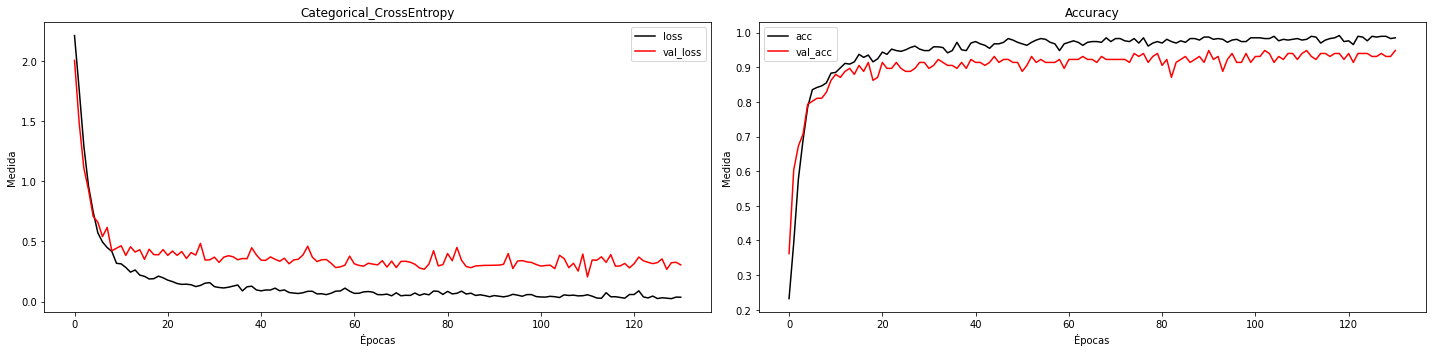

In [ ]:
#Plotemos el resultado de nuestro entrenamiento
fig, ejes = plt.subplots(nrows = 1, ncols=2,figsize=(20,5)) #aquí definimos que estén los dos gráficos una misma linea, por eso luego tenemos que indicar lo que va en eje 0 y eje 1
ejes[0].plot(history.history['loss'],color='black',label='loss')
ejes[0].plot(history.history['val_loss'],color='red',label='val_loss')
ejes[0].set_title("Categorical_CrossEntropy")
ejes[0].set_xlabel("Épocas")
ejes[0].set_ylabel("Medida")
ejes[0].legend(loc='best') 
ejes[1].plot(history.history['accuracy'],color='black',label='acc')
ejes[1].plot(history.history['val_accuracy'],color='red',label='val_acc')
ejes[1].set_title("Accuracy")
ejes[1].set_xlabel("Épocas")
ejes[1].set_ylabel("Medida")
ejes[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
#Utiizamos un rango del conjunto de test como si fueran imágenes nuevas que quisiera clasfificar
salidaPredicha = hypermodel.predict(X_test[:50,:,:,:])

In [ ]:
print(salidaPredicha.shape)

(50, 11)


In [ ]:
print(salidaPredicha[2].shape)

(11,)


[3.3162160e-14 4.5298968e-17 2.3059199e-15 1.0000000e+00 7.0533336e-12
 2.4526401e-19 6.1657476e-27 1.7486348e-20 3.8072840e-26 2.5655517e-14
 3.3508892e-13]
El color predicho es:  GREEN , label = 3


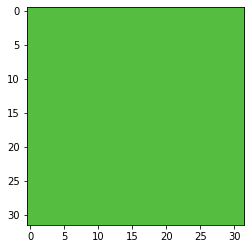

In [ ]:
idx = 6
print(salidaPredicha[idx]/np.max(salidaPredicha[idx])) #divido por np.max para encontrar rápido el 1 en las componentes del vector de salida
x=np.argmax(salidaPredicha,axis=1)
print ('El color predicho es: ',(CATEGORIES[x[idx]]).upper(), ', label =',x[idx] )
plt.imshow(X_test[idx])
plt.show()

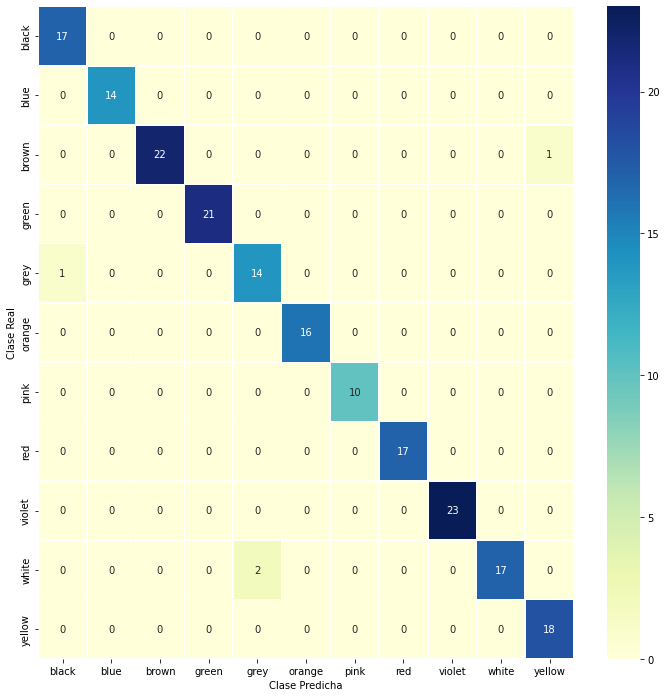

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred_y = hypermodel.predict(X_test)
y_pred = np.argmax(pred_y, axis=1)
y_true = np.argmax(y_testFinal, axis=1) 

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
heatmap= sns.heatmap(cm,cmap="YlGnBu",annot=True,linewidths=.5, ax=ax,
                     xticklabels=['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow'],
                     yticklabels=['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow'])
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.show()


ROC AUC score: 0.9891799934371247


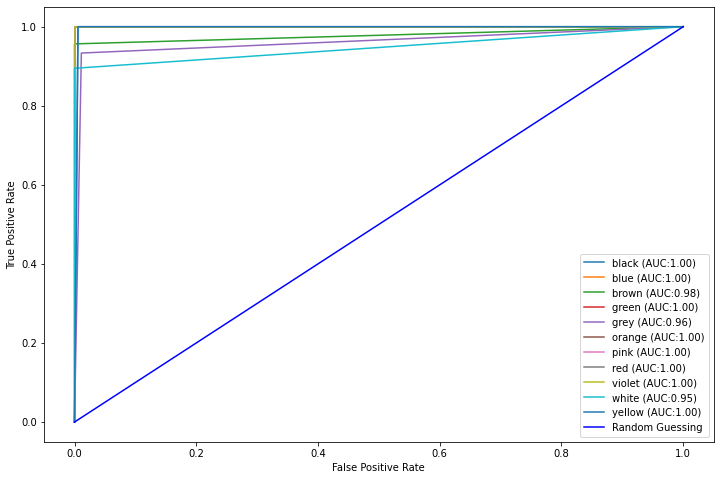

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#CATEGORIES = ['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow']

# establece el tamaño de la figura
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# función de puntuación roc auc para multiclase
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(CATEGORIES):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['black','blue','brown','green','grey','orange','pink','red','violet','white','yellow']
print(classification_report(y_true, y_pred, target_names=target_names))
            

              precision    recall  f1-score   support

       black       0.94      1.00      0.97        17
        blue       1.00      1.00      1.00        14
       brown       1.00      0.96      0.98        23
       green       1.00      1.00      1.00        21
        grey       0.88      0.93      0.90        15
      orange       1.00      1.00      1.00        16
        pink       1.00      1.00      1.00        10
         red       1.00      1.00      1.00        17
      violet       1.00      1.00      1.00        23
       white       1.00      0.89      0.94        19
      yellow       0.95      1.00      0.97        18

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.98      0.98      0.98       193



Guardar modelo entrenado para poder reutilizarlo más tarde

In [ ]:
#Guardo este modelo asignándole un nombre, lo guarda en mi directorio de trabajo actual (aparece en nuestra carpeta de la izquierda)
#Este modelo ya está entrenado y ya tiene asignados los pesos sinápticos y sesgos de la red neuronal
hypermodel.save('hypermodel_CNN_KT_AMPpink_09792')

INFO:tensorflow:Assets written to: hypermodel_CNN_KT_AMPpink_09792/assets


In [ ]:
#Comprimimos para que google colab nos lo deje descargarlo luego
!zip -r hypermodel.zip hypermodel_CNN_KT_AMPpink_09792

  adding: hypermodel_CNN_KT_AMPpink_09792/ (stored 0%)
  adding: hypermodel_CNN_KT_AMPpink_09792/keras_metadata.pb (deflated 90%)
  adding: hypermodel_CNN_KT_AMPpink_09792/variables/ (stored 0%)
  adding: hypermodel_CNN_KT_AMPpink_09792/variables/variables.index (deflated 64%)
  adding: hypermodel_CNN_KT_AMPpink_09792/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: hypermodel_CNN_KT_AMPpink_09792/saved_model.pb (deflated 88%)
  adding: hypermodel_CNN_KT_AMPpink_09792/assets/ (stored 0%)


In [ ]:
#Para volver a utilizarlo descomprimimos el zip que habíamos guardado y descargado
#!unzip modelo.zip -d modeloNuevo

In [ ]:
#Cargamos el modelo que hemos descomprimido, OJO hay que poner su ruta completa (lo ha guardado dentro de modeloNuevo/modeloCNN)
#from tensorflow.keras.models import load_model
#modeloCargado = load_model('modeloNuevo/modeloCNN')

In [ ]:
#Volvemos a entrenarlo con los datos que teníamos de test y tiene que darnos de nuevo el mismo resultado de loss y accuracy
#resTest2 = modeloCargado.evaluate(X_test, y_testFinal,verbose=0)

In [ ]:
#print(resTest2)